In [1]:
%run imports.py

In [2]:
def get_mask_area_ratio(mask):
    foreground = (mask == 1).sum().item() 
    total_pixels = mask.numel() 
    return foreground / total_pixels


def get_train_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] not in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    train_data = ConcatDataset(test_subsets)
    
    train_dataset = KvasirDataset(data=train_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return train_dataset


def get_test_dataset(subsets_path, choosen_test_subsets = ["i", "j"]):
    test_subsets = []
    for subset in os.listdir(subsets_path):
        if subset.split(".")[0].split("_")[1] in choosen_test_subsets:
            with open(f'{subsets_path}/{subset}', "rb") as f:
                data = pickle.load(f)
            test_subsets.append(data)
    test_data = ConcatDataset(test_subsets)
    
    test_dataset = KvasirDataset(data=test_data, 
                                 mode="test", 
                                 image_size=ast.literal_eval(env_vars["image_size"]), 
                                 mask_size=ast.literal_eval(env_vars["mask_size"]))
    
    return test_dataset

test_dataset = get_test_dataset(subsets_path=f"../data/subsets")

In [21]:
def get_best_model_area_vs_dice(data, model_name, model_config, ckpt_path, device):
    model = select_model(model_name=model_name, model_config=model_config)
    
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    area_vs_score_list = []

    for i in range(len(data)):
        image, mask = data[i][0].to(device), data[i][1].to(device)
        area_ratio = get_mask_area_ratio(mask)

        with torch.no_grad():
            preds = model(image.unsqueeze(0)).squeeze(0)
            dice_score = calculate_dice_score(preds=preds, targets=mask, device=device, model_name=model_name)

        area_vs_score_list.append((area_ratio, dice_score.item()))

    return area_vs_score_list


def plot_best_model_butterfly_mask_vs_score(n_bins, threshold, results, fname):
    mask_bins = np.linspace(0.0, 1.0, n_bins + 1)
    data_bins = [[] for _ in range(n_bins)]

    for area, score in results:
        for j in range(n_bins):
            if mask_bins[j] <= area < mask_bins[j + 1]:
                data_bins[j].append(score)
                break

    butterfly_data = [
        (
            sum(score < threshold for score in bin_scores),  # below
            sum(score > threshold for score in bin_scores)   # above
        )
        for bin_scores in data_bins
    ]

    below_counts = [x[0] for x in butterfly_data]
    above_counts = [x[1] for x in butterfly_data]

    bar_width = 0.35
    index = np.arange(n_bins)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(index, -np.array(below_counts), bar_width, color='blue', label=f'Below Threshold (< DSC={threshold})')
    ax.bar(index, above_counts, bar_width, color='red', label=f'Above Threshold (> DSC={threshold})')

    ax.axhline(y=0, color='black', linestyle='--')

    for i in range(n_bins):
        ax.text(i, -below_counts[i] - 0.5, str(below_counts[i]), ha='center', va='top', fontsize=9)
        ax.text(i, above_counts[i] + 0.5, str(above_counts[i]), ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Mask Area Ratio Bins')
    ax.set_ylabel('Dice Score Counts')
    ax.set_xticks(index)
    ax.set_xticklabels([f'{mask_bins[i]:.2f}-{mask_bins[i+1]:.2f}' for i in range(n_bins)])
    ax.legend()
    # ax.set_title(f"Dice Score Distribution Across Mask Size Bins (Threshold = {threshold})")

    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{fname}.png")
    plt.show()


In [4]:
ckpt_path = "/mnt/d/research-data/train_oversample_old/train_oversample_split20_old/models"

pre_oversample_model_name = "pre_oversample.segformer_b2.size_384x96.pt"

area_vs_score_results_pre = get_best_model_area_vs_dice(data=test_dataset, 
                                                    model_name=env_vars["model_name"], 
                                                    model_config=env_vars["model_config"], 
                                                    ckpt_path=f'{ckpt_path}/{pre_oversample_model_name}', 
                                                    device="cuda")


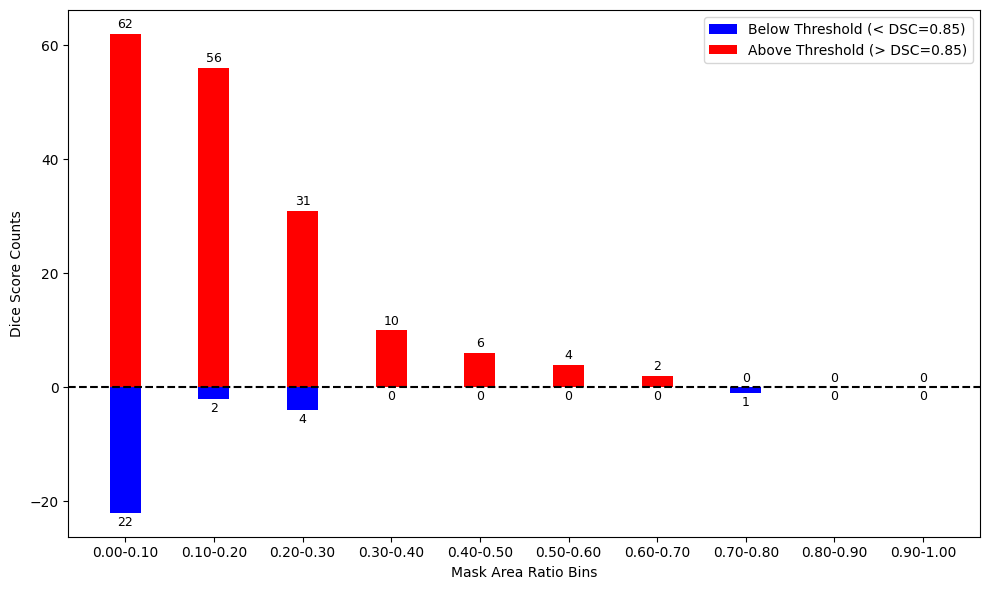

In [28]:
plot_best_model_butterfly_mask_vs_score(n_bins=10, 
                                        threshold=0.85, 
                                        results=area_vs_score_results_pre, 
                                        fname="pre_oversampling")

In [6]:
ckpt_path = "/mnt/d/research-data/train_oversample_old/train_oversample_split20_old/models"
post_oversample_model_name = "post_oversample.iter6.segformer_b2.size_384x96.pt"


area_vs_score_results_post = get_best_model_area_vs_dice(data=test_dataset, 
                                                    model_name=env_vars["model_name"], 
                                                    model_config=env_vars["model_config"], 
                                                    ckpt_path=f'{ckpt_path}/{post_oversample_model_name}', 
                                                    device="cuda")

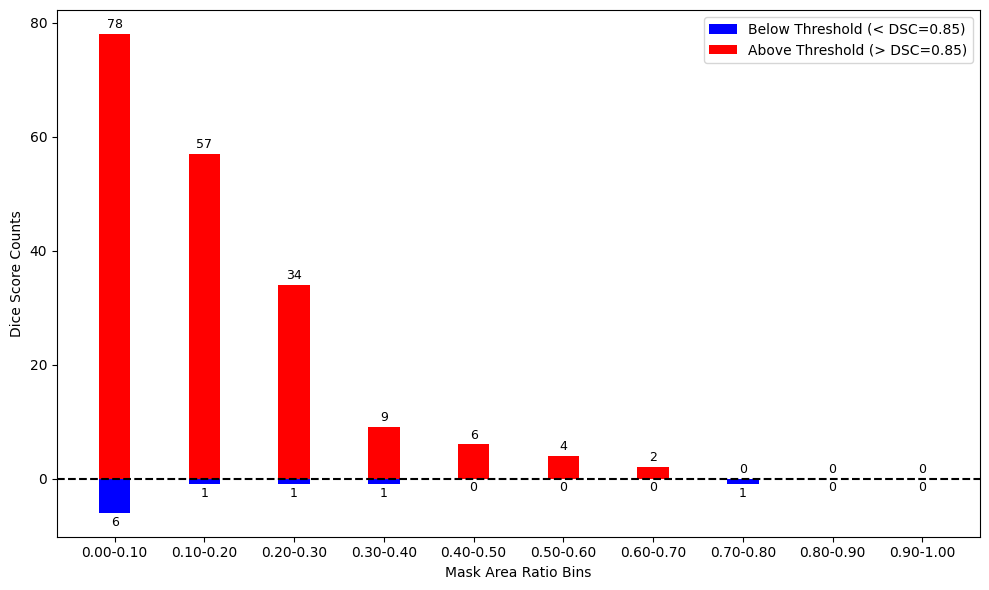

In [29]:
plot_best_model_butterfly_mask_vs_score(n_bins=10, 
                                        threshold=0.85, 
                                        results=area_vs_score_results_post, 
                                        fname="post_oversampling")